# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.shape

(7591, 2)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Размер выборки выведен. Выборка относительно небольшая, но мы еще можем нарастить ее, применяя аугментации


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


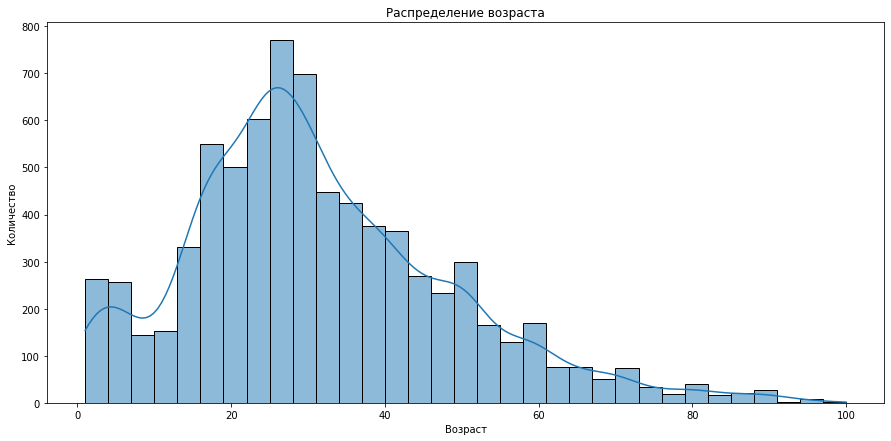

In [5]:
print(labels['real_age'].describe())
plt.figure(figsize=(15, 7))
ax = sns.histplot(labels, x='real_age', binwidth=3, kde=True, bins=100)
ax.set(xlabel='Возраст', ylabel='Количество', title='Распределение возраста')

plt.show()

Файл: 000000.jpg
Возраст: 4
Размерность: (114, 114, 3)


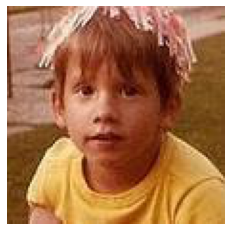

Файл: 000001.jpg
Возраст: 18
Размерность: (784, 784, 3)


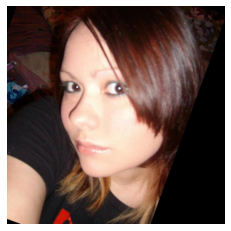

Файл: 000002.jpg
Возраст: 80
Размерность: (133, 133, 3)


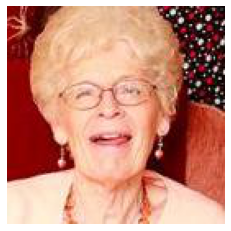

Файл: 000003.jpg
Возраст: 50
Размерность: (370, 370, 3)


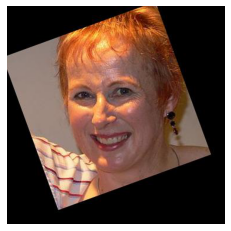

Файл: 000004.jpg
Возраст: 17
Размерность: (212, 212, 3)


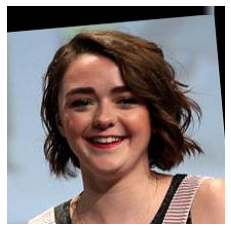

Файл: 000005.jpg
Возраст: 27
Размерность: (636, 637, 3)


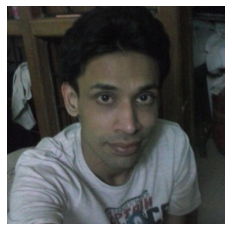

Файл: 000006.jpg
Возраст: 24
Размерность: (412, 412, 3)


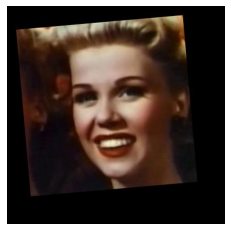

Файл: 000007.jpg
Возраст: 43
Размерность: (311, 311, 3)


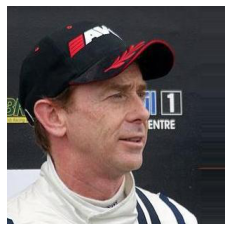

Файл: 000008.jpg
Возраст: 26
Размерность: (898, 897, 3)


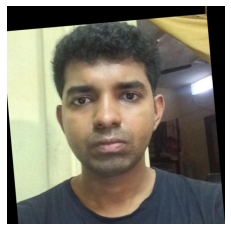

Файл: 000009.jpg
Возраст: 39
Размерность: (724, 724, 3)


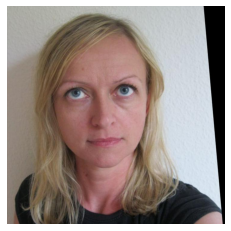

In [6]:
for i in range(10):
    print('Файл:', labels.loc[i, 'file_name'])
    print('Возраст:', labels.loc[i, 'real_age'])
    file_dir = '/datasets/faces/final_files/00000'+ str(i) + '.jpg'
    image = Image.open(file_dir)
    array = np.array(image)
    
    print('Размерность:', array.shape) 
    plt.imshow(array)
    plt.axis('off')
    plt.show()

### Выводы:
- В датасете находится 7591 объектов, которые содержат 2 признака: название файла фотографии и возраст человека на фотографии. Целевой признак - целочисленное число, обозначающее возраст.
- Изображение: фотопортрет человека в формате jpg, квадратная форма, цветной вид, три цветовых канала RGB, размер у всех объектов разный, может содержать артефакты в виде чёрного фона, оставленного после обрезания фото. Все лица расположены вертикально и занимают бОльшую часть изображения. 
- Возраст: данные распределены нормально от 1 до 100 со смещение влево. Математическое ожидание приходится на 31 год, стандартное отклонение - 17 лет, медиана - 29 лет. Требуется выравнить распределение количества объектов между разными возрастами для равной вероятности их предсказания.
- В данных нет пропусков.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Модель определена правильно! Отлично, что применен горизонтальный флип на тренировочной части

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-10-01 09:24:37.526007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-01 09:24:38.181355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 188s - loss: 248.7285 - mae: 11.1392 - val_loss: 508.7177 - val_mae: 17.4317
Epoch 2/5
356/356 - 50s - loss: 87.5042 - mae: 7.0984 - val_loss: 131.6930 - val_mae: 8.8824
Epoch 3/5
356/356 - 50s - loss: 59.5497 - mae: 5.8379 - val_loss: 124.4151 - val_mae: 8.4985
Epoch 4/5
356/356 - 50s - loss: 44.5000 - mae: 5.1113 - val_loss: 74.4241 - val_mae: 6.3683
Epoch 5/5
Test MAE: 6.6377
```

## Анализ обученной модели

- Итоговая модель построена с использованием 4 слоев:
    1. ResNet50 backbone: Это предобученная модель ResNet50, которая используется в качестве основы для нашей модели. 
    2. GlobalAveragePooling2D:  Слой, который усредняет признаки по пространственным измерениям входных данных.
    3. Dense (с 1 нейроном и активацией ReLU): Полносвязный слой, который выполняет линейную комбинацию входных данных и применяет функцию активации ReLU. 
    4. Выходной слой (неявный): задаются loss-функция, метрика MAE и оптимайзер Adam.
- Результатом обучения модели на 5 эпохах стало МАЕ, равное 6.64 < 8. Следовательно, задание выполнено.
- Полученный результат говорит о том, что модель ошибается в среднем на +-6 лет при определении возраста изображенного на фото человека.